In [ ]:
import pickle

inst_array = []
# insts = 　　[　　'東京大学',　　'東北大学',　　'東京工業大学'　　]
# テキストファイルを読み込んで配列に代入
with open('kikanmei.txt', 'r',encoding="utf-8_sig") as f:
    insts = f.read().split("\n")

for inst in insts:
    inst_array.append(inst)
with open("inst_array.pkl","wb") as f:
    pickle.dump(inst_array, f)

In [ ]:
import pickle

with open('inst_array.pkl', 'rb') as f:
    institutions = pickle.load(f)
    
## 必要なライブラリのインポート ————–
# スクレイピング
from bs4 import BeautifulSoup
import time
import requests
import traceback
import logging
logger = logging.getLogger()

def main():
  type_list = {}
  #type_list = scrap('東北大学')
  for kikan in institutions:
    time.sleep(1)
    # 1秒スリープ
    type_list[kikan] = scrap(kikan)
    # type_list = scrap(kikan)
  # print(type_list)
  return type_list

def scrap(kikan):
  URL = 'https://irdb.nii.ac.jp/search?kikanid=' + kikan
  # スクレイピング —————————
  try:
    # URLを開く
    response = requests.get(URL)
    # HTMLを取得
    soup = BeautifulSoup(response.content, 'html.parser')
    logger.info('webサイトと接続できました')
  except:
    tb = traceback.format_exc()
    print(tb)
    print('Webサイトとの接続が確立できませんでした')

  # HTML上の任意の箇所を抽出
  '''
  <section class="facet-inactive block-facet--links block block-facets block-facet-blockresourcetype clearfix"
   id="block-resourcetype">
  <li class="facet-item"><a href="/search?kikanid=%E6%9D%B1%E4%BA%AC%E5%A4%A7%E5%AD%A6&amp;
  facet%5B0%5D=typefc%3Abook" rel="nofollow" 
  data-drupal-facet-item-id="typefc-book" data-drupal-facet-item-value="book"
  data-drupal-facet-item-count="109"><span class="facet-item__value">book</span>
  <span class="facet-item__count">(109)</span>
  '''
  soup2 = soup.select('#block-resourcetype a')
  # テキストのみをリストで取得
  soup_list = [[kikan, x.attrs['data-drupal-facet-item-value'], x.attrs['data-drupal-facet-item-count']] for x in soup2]
  return soup_list

# pickle　で置き換え
# institutions = ['東京大学','東北大学','東京工業大学']

if __name__ == "__main__":
    type_list = main()
    
# 600件で18分程度(sleep(1))

In [ ]:
# データ加工
import pandas as pd
# list化
listOfValues = list(type_list.values())
# フラット化
flat_list = [item for l in listOfValues for item in l]
koumoku = ['institutions', 'typename', 'nums']
# 項目名を加えて辞書化
listext = []
for v in flat_list:
    listext.append(dict(zip(koumoku,v)))
    # print(listext)
# pandasのDataFrame化
df = pd.DataFrame(listext)
# df
pivot_orders_df = df.pivot_table(values=['nums'], index=['institutions'], columns=['typename'], aggfunc='sum')
pivot_orders_df = pivot_orders_df.rename(index={'': '全体'})
pivot_orders_df.fillna(0,inplace=True)
pivot_orders_df


In [ ]:
df.to_pickle('test.pkl.gz', compression='gzip') # 圧縮有り

In [ ]:
# pivot_orders_df
#pivot_orders_df_reset = pivot_orders_df.reset_index(level=0)
pivot_orders_df.columns = pivot_orders_df.columns.droplevel(0)
#pandas 0.18.0 and higher
pivot_orders_df = pivot_orders_df.rename_axis(None, axis=1)
pivot_orders_df

In [ ]:
# pivot_orders_df
# cols = pivot_orders_df.columns.drop('institutions')
cols = pivot_orders_df.columns
pivot_orders_df[cols] = pivot_orders_df[cols].apply(pd.to_numeric, errors='coerce')
# pivot_orders_df.iloc[:,[0,2]] = pd.to_numeric(pivot_orders_df.iloc[:,[0,2]], errors='coerce')
# pivot_orders_df["article"] = pd.to_numeric(pivot_orders_df["article"], errors='coerce')


In [ ]:
# 前回保存したDataFrameのファイルから読み込む
import pandas as pd
pivot_orders_df = pd.read_pickle('./pivot_orders_df.pkl.gz', compression='gzip') # 圧縮有り

In [ ]:
# 'article == 113164'は総計の数字。IRDBは検索該当なしだと全件になってしまうので。
# IRDBは、JPCOAR外のリポジトリも含んだ数字なので、総計は削除してよい
# print((pivot_orders_df.query('article == 113164')))
pivot_orders_df_2index = list(pivot_orders_df.query('article == 113164').index)
# del pivot_orders_df_2index[:2]  # 先頭から２つ[全体,＃NA]をlistから削除する場合
pivot_orders_df_2index  # 削除するindexのlist
# index で指定した行をまとめて削除したDFを生成
pivot_orders_df2 = pivot_orders_df.drop(index=pivot_orders_df_2index)

# pivot_orders_df

C:\Users\libso23-user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 26481 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\libso23-user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\libso23-user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 24037 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\libso23-user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 26989 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\libso23-user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 22823 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\libso23-user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: 

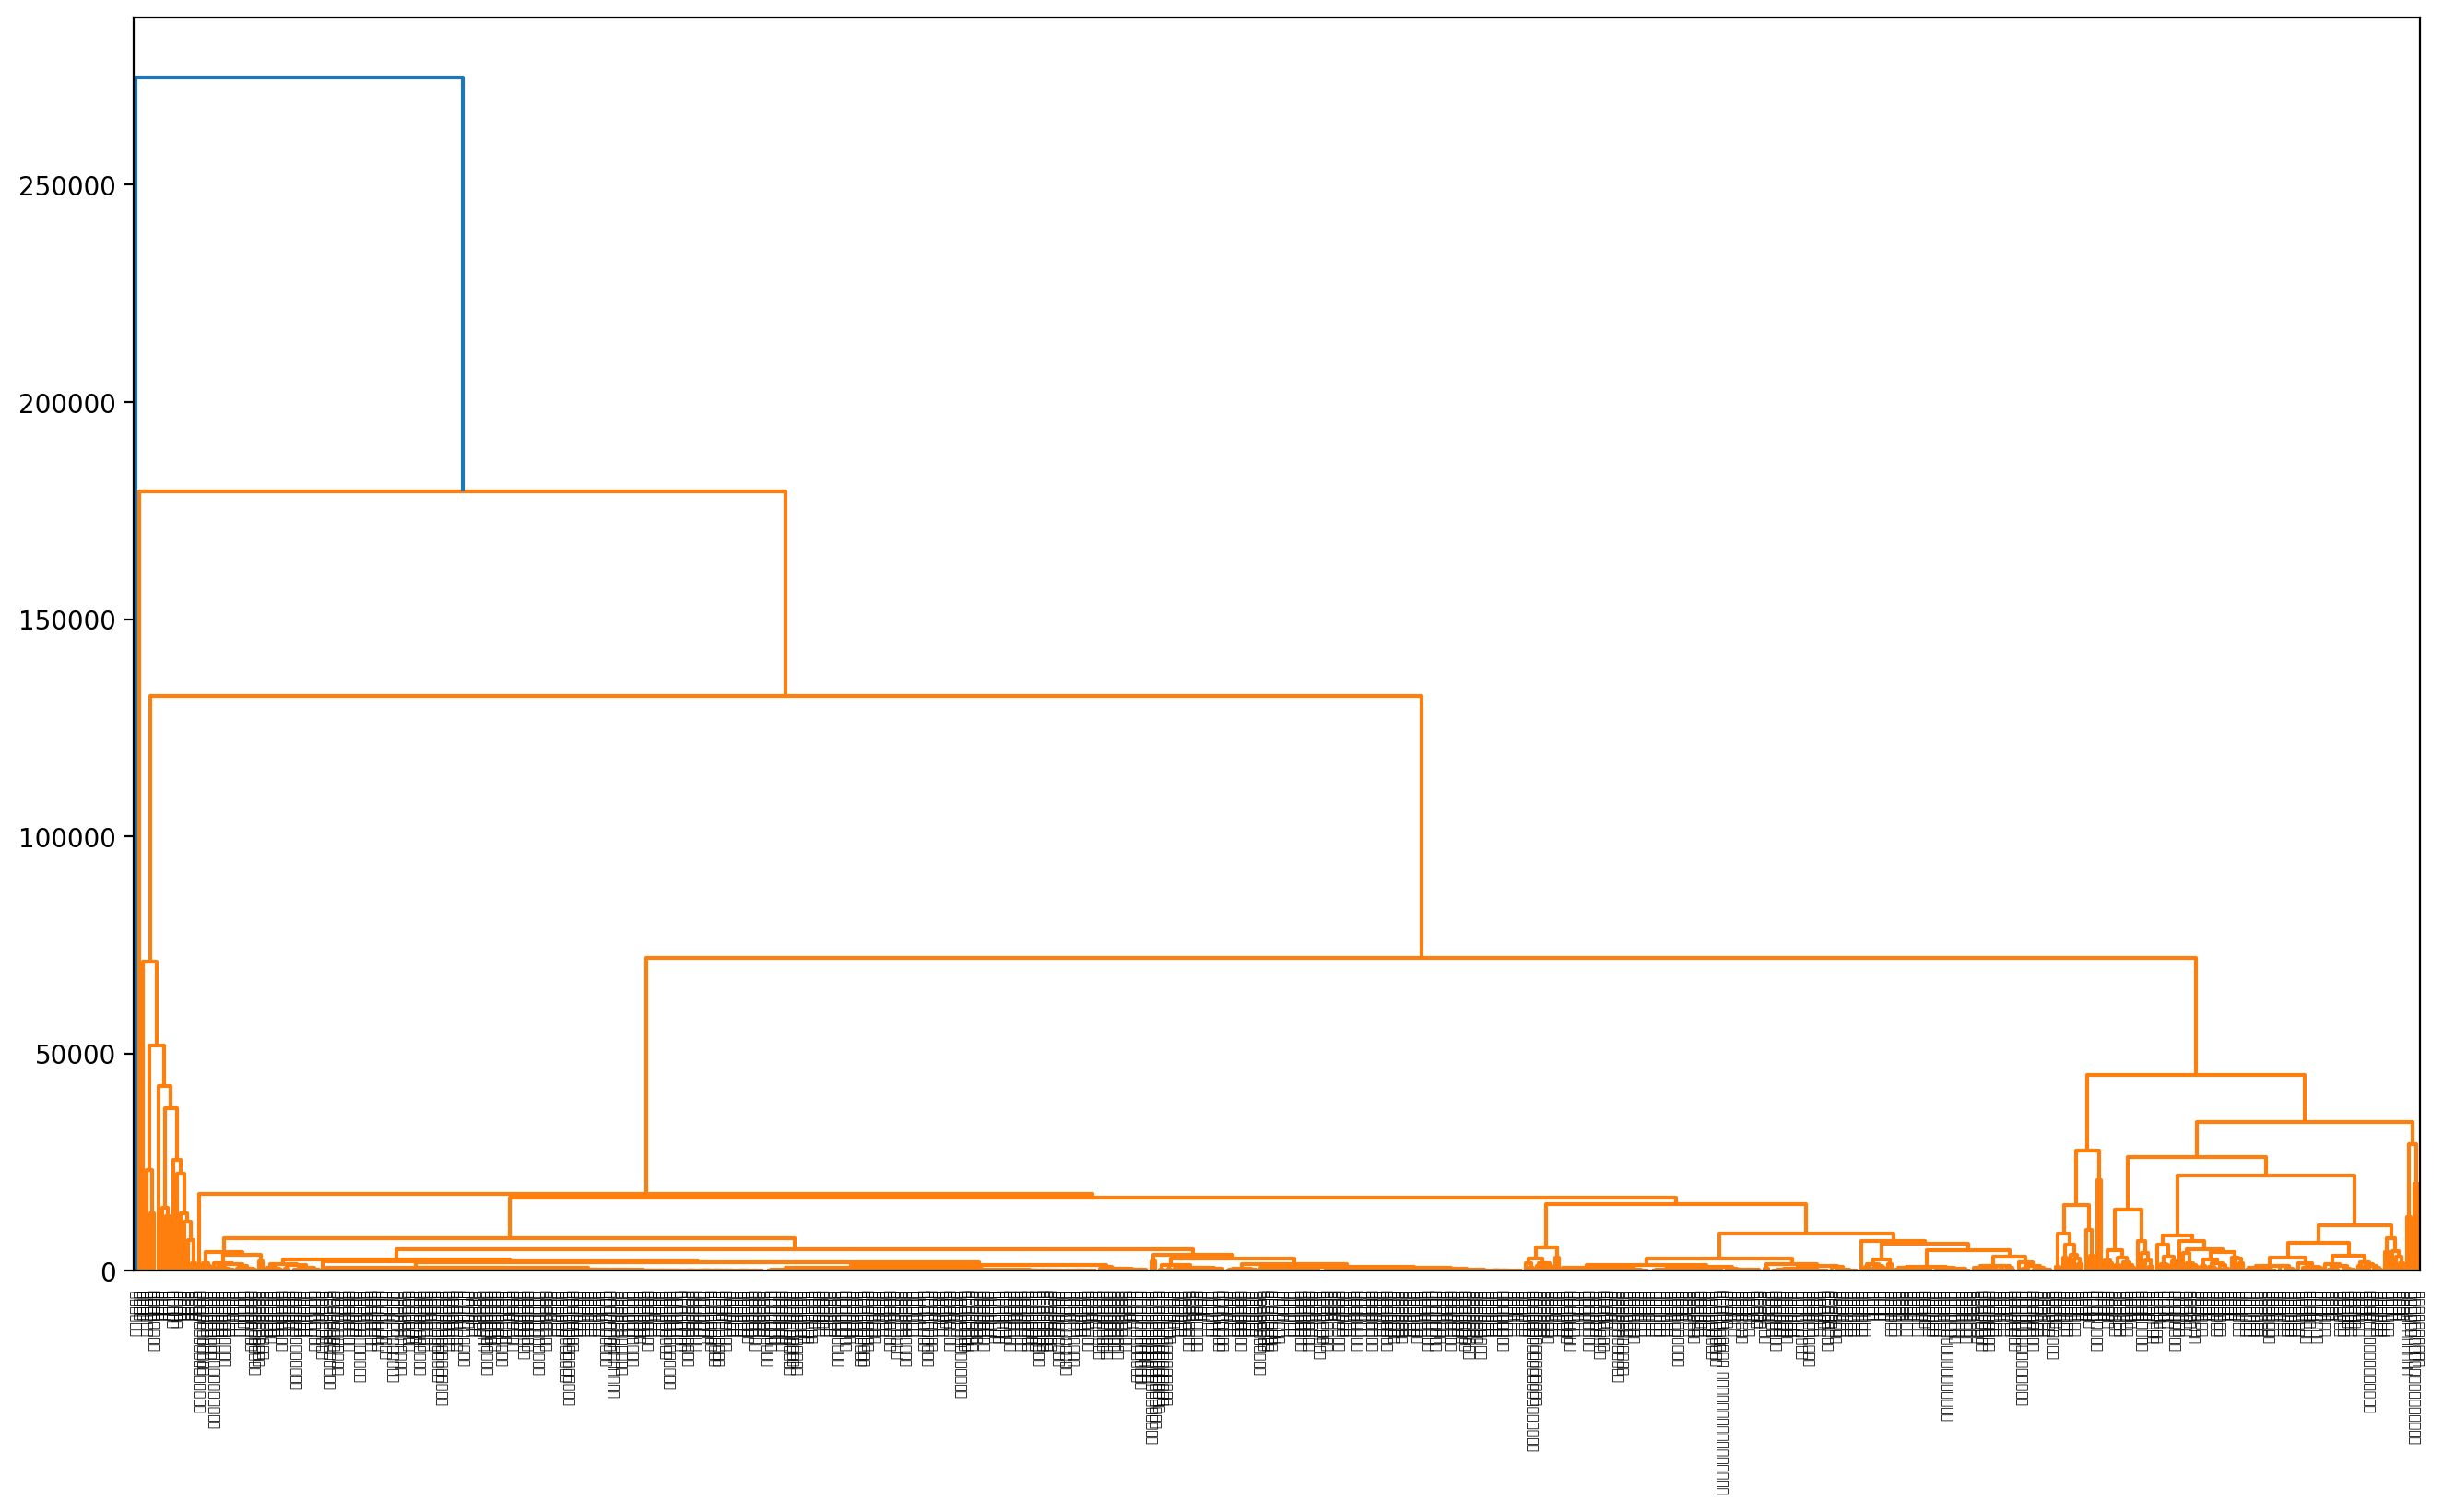

In [5]:
# 階層型クラスタリング(ウォード法)
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
 
linkage_result = linkage(pivot_orders_df2, method='ward', metric='euclidean')
plt.figure(num=None, figsize=(16, 9), dpi=200, facecolor='w', edgecolor='k')
dendrogram(linkage_result, labels=pivot_orders_df2.index)
plt.show()
# 24.4s

In [48]:
# 【python】scipyで階層型クラスタリングするときの知見まとめ
# https://www.haya-programming.com/entry/2019/02/11/035943#linkage
import numpy as np
from collections import defaultdict
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.datasets import load_digits

def gen_data():
    digits = load_digits()
    label_uniq = np.unique(digits.target)
    result = []
    for label in label_uniq:
        result.append(digits.data[digits.target == label].mean(axis=0))
    return result, label_uniq

def clustering_fcluster():
    X, y = gen_data()
    S = pdist(X)
    # ユークリッド距離とウォード法を使用してクラスタリング
    # Z = linkage(pivot_orders_df2, metric='euclidean', method='ward')
    Z = linkage(pivot_orders_df2, metric='euclidean', method='average')
    # Z = linkage(pivot_orders_df2, method="average")
    # criterion= ‘maxclust’、最大クラスタ数
    # ’distance’ 距離で閾値を指定
    # inconsistent (default)
    # monocrit, maxclust_monocrit
    result = fcluster(Z, t=7, criterion="maxclust")
    # result = fcluster(Z, t=5, criterion="distance")
    d = defaultdict(list)
    for i, r in enumerate(result):
        d[r].append(i)
    for k, v in d.items():
        print(k, pivot_orders_df2.index[v])
        # print(k,v) # v は行番号のリスト
        
if __name__ == "__main__":
    clustering_fcluster()

3 Index(['お茶の水女子大学', 'こども教育宝仙大学', 'つくば国際大学', 'びわこ成蹊スポーツ大学', 'ものつくり大学',
       'アジア成長研究所', 'デジタルハリウッド大学', 'ノートルダム清心女子大学', 'フェリス女学院大学', 'ヤマザキ動物看護大学',
       ...
       '鶴見大学', '鹿児島国際大学', '鹿児島大学', '鹿児島女子短期大学', '鹿児島県立短期大学', '鹿児島純心女子大学',
       '鹿児島純心女子短期大学', '鹿屋体育大学', '麗澤大学', '麻布大学'],
      dtype='object', name='institutions', length=602)
6 Index(['京都大学'], dtype='object', name='institutions')
4 Index(['北海道大学', '大阪大学', '早稲田大学', '東京大学', '筑波大学'], dtype='object', name='institutions')
5 Index(['千葉大学'], dtype='object', name='institutions')
1 Index(['慶應義塾大学'], dtype='object', name='institutions')
7 Index(['東京工業大学'], dtype='object', name='institutions')
2 Index(['東北大学'], dtype='object', name='institutions')


In [37]:
# pivot_orders_df2[45:46]
pivot_orders_df2.iloc[[286,380], :]

,article,bachelor thesis,book,book part,cartographic material,conference object,conference paper,conference poster,conference proceedings,data paper,...,report,report part,research report,review article,software,sound,still image,technical report,thesis,working paper
institutions,,,,,,,,,,,,,,,,,,,,,
慶應義塾大学,3376,0,393,0,0,0,0,0,0,0,...,0,0,4424,0,0,0,0,2353,10952,0
東北大学,0,0,2,0,0,50,0,0,0,0,...,0,0,0,0,0,0,0,0,4757,0


In [6]:
linkage_result

array([[5.30000000e+01, 5.61000000e+02, 1.00000000e+00, 2.00000000e+00],
       [4.57000000e+02, 5.63000000e+02, 1.00000000e+00, 2.00000000e+00],
       [2.89000000e+02, 3.87000000e+02, 1.00000000e+00, 2.00000000e+00],
       ...,
       [1.21800000e+03, 1.21900000e+03, 1.32208118e+05, 6.10000000e+02],
       [4.50000000e+01, 1.22000000e+03, 1.79322209e+05, 6.11000000e+02],
       [3.58000000e+02, 1.22100000e+03, 2.74675801e+05, 6.12000000e+02]])

In [ ]:
# 行と列に合計値を追加する 
pivot_orders_df2 = pd.concat([pivot_orders_df2,pd.DataFrame(pivot_orders_df2.sum(axis=0),columns=['Grand Total']).T])
pivot_orders_df2 = pd.concat([pivot_orders_df2,pd.DataFrame(pivot_orders_df2.sum(axis=1),columns=['Total'])],axis=1)
pivot_orders_df2

In [ ]:
# Totalの降順にソートする
pivot_orders_df3 = pivot_orders_df2.sort_values(by='Total', ascending=False) 
# 日付をファイル名にしてエクセルに出力
import datetime
now = datetime.datetime.now()
filename = './irdbscraping_' + now.strftime('%Y%m%d_%H%M%S') + '.xlsx'
pivot_orders_df3.to_excel('./'+filename, sheet_name='filename')

In [ ]:
pivot_orders_df.to_pickle('./pivot_orders_df.pkl.gz', compression='gzip') # 圧縮有り
# pd.read_pickle('test.pkl.gz', compression='gzip') # 圧縮有り